# Coverage Distribution plot

In [26]:
import pymc as pm
import formulaic
import pandas as pd
import numpy as np

import pandas as pd

data = pd.read_csv("../single_parameter/combined_data/statistics.csv")
data.head()

model_formula = 'Coverage ~ 0 + C(TargetModule)'
model_spec = formulaic.model_matrix(model_formula, data=data)

model_spec.rhs.iloc[:, :20]

C(TargetModule)[T.codetiming._timer]  \
0                                        0   
1                                        1   
2                                        1   
3                                        0   
4                                        0   
...                                    ...   
9355                                     0   
9356                                     0   
9357                                     0   
9358                                     0   
9359                                     0   

      C(TargetModule)[T.flutils.decorators]  \
0                                         1   
1                                         0   
2                                         0   
3                                         1   
4                                         0   
...                                     ...   
9355                                      0   
9356                                      0   
9357                                      0   
9358                                      0   
9359                                      0   

      C(TargetModule)[T.flutils.namedtupleutils]  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
9355                                           0   
9356                                           0   
9357                                           0   
9358                                           0   
9359                                           0   

      C(TargetModule)[T.flutils.packages]  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   
...                                   ...   
9355                                    0   
9356                                    0   
9357                                    0   
9358                                    0   
9359                                    0   

      C(TargetModule)[T.flutils.setuputils.cmd]  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
9355                                          0   
9356                                          0   
9357                                          0   
9358                                          0   
9359                                          0   

      C(TargetModule)[T.httpie.output.formatters.headers]  \
0                                                     0     
1                                                     0     
2                                                     0     
3                                                     0     
4                                                     1     
...                                                 ...     
9355                                                  0     
9356                                                  0     
9357                                                  0     
9358                                                  0     
9359                                                  0     

      C(TargetModule)[T.httpie.plugins.base]  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   
...                                      ...   
9355                                    

In [27]:
with pm.Model() as model:
    # Priors for the global intercept
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard deviation across groups
    sigma = pm.Exponential('sigma', 1.5)
    
    # Group-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma, shape=model_spec.rhs.shape[1])
    
    # Deterministic transformations for logit(pi)
    logit_p = pm.math.dot(model_spec.rhs, a_m)
    
    # Link function - logistic
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    
    # Gamma distribution for theta - dispersion parameter
    #theta = pm.Gamma('theta', alpha=2, beta=0.5)  # adjust alpha, beta to reflect your prior knowledge
    
    theta = pm.Uniform('theta', 40, 150)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=model_spec.lhs['Coverage'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4, return_inferencedata=True, progressbar=True)

print("Model building complete.")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma, a_m, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.


Model building complete.


In [30]:
import arviz as az
column_names = model_spec.rhs.columns
# Iterate over the column names and print out the mapping
for i, name in enumerate(column_names):
    category = name.split('[')[-1].rstrip(']')
    print(f'a_m[{i}]: {category}')


def logit_to_probability(logit_vals):
    """Apply logistic transformation to logit values."""
    return 1 / (1 + np.exp(-logit_vals))


# Create a dictionary for the posterior
posterior_dict = {
    'a_m': trace.posterior['a_m'].values,
    'a_bar': trace.posterior['a_bar'].values,
    'sigma': trace.posterior['sigma'].values
    
}

for key, value in posterior_dict.items():
    posterior_dict[key] = logit_to_probability(value)


posterior_dict['theta'] = trace.posterior['theta'].values

# Create an InferenceData object
infdata = az.from_dict(posterior=posterior_dict)

# Generate a summary table with the mean and 89% HDI for all variables
summary = az.summary(infdata, hdi_prob=0.89)
summary



a_m[0]: T.codetiming._timer
a_m[1]: T.flutils.decorators
a_m[2]: T.flutils.namedtupleutils
a_m[3]: T.flutils.packages
a_m[4]: T.flutils.setuputils.cmd
a_m[5]: T.httpie.output.formatters.headers
a_m[6]: T.httpie.plugins.base
a_m[7]: T.mimesis.builtins.da
a_m[8]: T.py_backwards.transformers.base
a_m[9]: T.py_backwards.transformers.dict_unpacking
a_m[10]: T.py_backwards.transformers.return_from_generator
a_m[11]: T.py_backwards.transformers.yield_from
a_m[12]: T.py_backwards.utils.helpers
a_m[13]: T.pymonet.immutable_list
a_m[14]: T.pymonet.maybe
a_m[15]: T.pymonet.validation
a_m[16]: T.pypara.accounting.journaling
a_m[17]: T.pytutils.lazy.lazy_import
a_m[18]: T.pytutils.python
a_m[19]: T.sanic.config
a_m[20]: T.sanic.helpers
a_m[21]: T.sanic.mixins.signals
a_m[22]: T.thonny.plugins.pgzero_frontend
a_m[23]: T.typesystem.tokenize.positional_validation


mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a_m[0]    0.873  0.002     0.869      0.877      0.000    0.000    8678.0   
a_m[1]    0.663  0.004     0.657      0.669      0.000    0.000   10854.0   
a_m[2]    0.933  0.002     0.930      0.935      0.000    0.000    8952.0   
a_m[3]    0.052  0.002     0.050      0.055      0.000    0.000    9588.0   
a_m[4]    0.077  0.002     0.074      0.080      0.000    0.000    9482.0   
a_m[5]    0.598  0.004     0.591      0.603      0.000    0.000    8798.0   
a_m[6]    0.747  0.003     0.742      0.753      0.000    0.000   11068.0   
a_m[7]    0.793  0.003     0.788      0.798      0.000    0.000    9934.0   
a_m[8]    0.279  0.003     0.274      0.284      0.000    0.000   10778.0   
a_m[9]    0.140  0.003     0.136      0.144      0.000    0.000    9679.0   
a_m[10]   0.226  0.003     0.220      0.230      0.000    0.000   10591.0   
a_m[11]   0.489  0.004     0.483      0.495      0.000    0.000    9919.0   
a_m[12]   0.633  0.004     0.627      0.639      0.000    0.000    9819.0   
a_m[13]   0.750  0.003     0.744      0.755      0.000    0.000    8841.0   
a_m[14]   0.907  0.002     0.904      0.911      0.000    0.000    8752.0   
a_m[15]   0.907  0.002     0.904      0.910      0.000    0.000    8934.0   
a_m[16]   0.324  0.003     0.319      0.329      0.000    0.000    9389.0   
a_m[17]   0.470  0.004     0.464      0.476      0.000    0.000    8771.0   
a_m[18]   0.229  0.003     0.224      0.234      0.000    0.000   11701.0   
a_m[19]   0.783  0.003     0.778      0.788      0.000    0.000    8118.0   
a_m[20]   0.753  0.003     0.748      0.758      0.000    0.000    9413.0   
a_m[21]   0.195  0.003     0.191      0.200      0.000    0.000   10149.0   
a_m[22]   0.598  0.004     0.592      0.603      0.000    0.000    9978.0   
a_m[23]   0.286  0.003     0.280      0.292      0.000    0.000    9645.0   
a_bar     0.531  0.073     0.424      0.652      0.001    0.001    7293.0   
sigma     0.820  0.031     0.771      0.869      0.000    0.000    8050.0   
theta    42.368  0.624    41.363     43.316      0.009    0.007    4827.0   

         ess_tail  r_hat  
a_m[0]     2880.0    1.0  
a_m[1]     2577.0    1.0  
a_m[2]     2925.0    1.0  
a_m[3]     2635.0    1.0  
a_m[4]     2877.0    1.0  
a_m[5]     3020.0    1.0  
a_m[6]     2929.0    1.0  
a_m[7]     2516.0    1.0  
a_m[8]     2890.0    1.0  
a_m[9]     3020.0    1.0  
a_m[10]    2437.0    1.0  
a_m[11]    2874.0    1.0  
a_m[12]    2880.0    1.0  
a_m[13]    2580.0    1.0  
a_m[14]    2653.0    1.0  
a_m[15]    3168.0    1.0  
a_m[16]    2969.0    1.0  
a_m[17]    2652.0    1.0  
a_m[18]    2801.0    1.0  
a_m[19]    2938.0    1.0  
a_m[20]    3235.0    1.0  
a_m[21]    3044.0    1.0  
a_m[22]    3019.0    1.0  
a_m[23]    2975.0    1.0  
a_bar      2626.0    1.0  
sigma      3168.0    1.0  
theta      2146.0    1.0

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

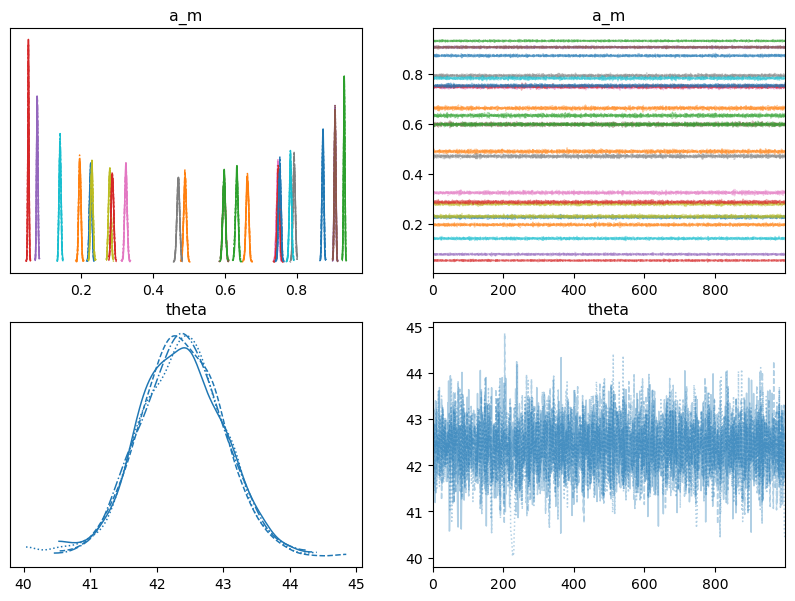

In [32]:
az.plot_trace(posterior_dict, var_names=['a_m', 'theta'], figsize=(10, 7))

Sampling: [Y_obs, a_bar, a_m, sigma, theta]


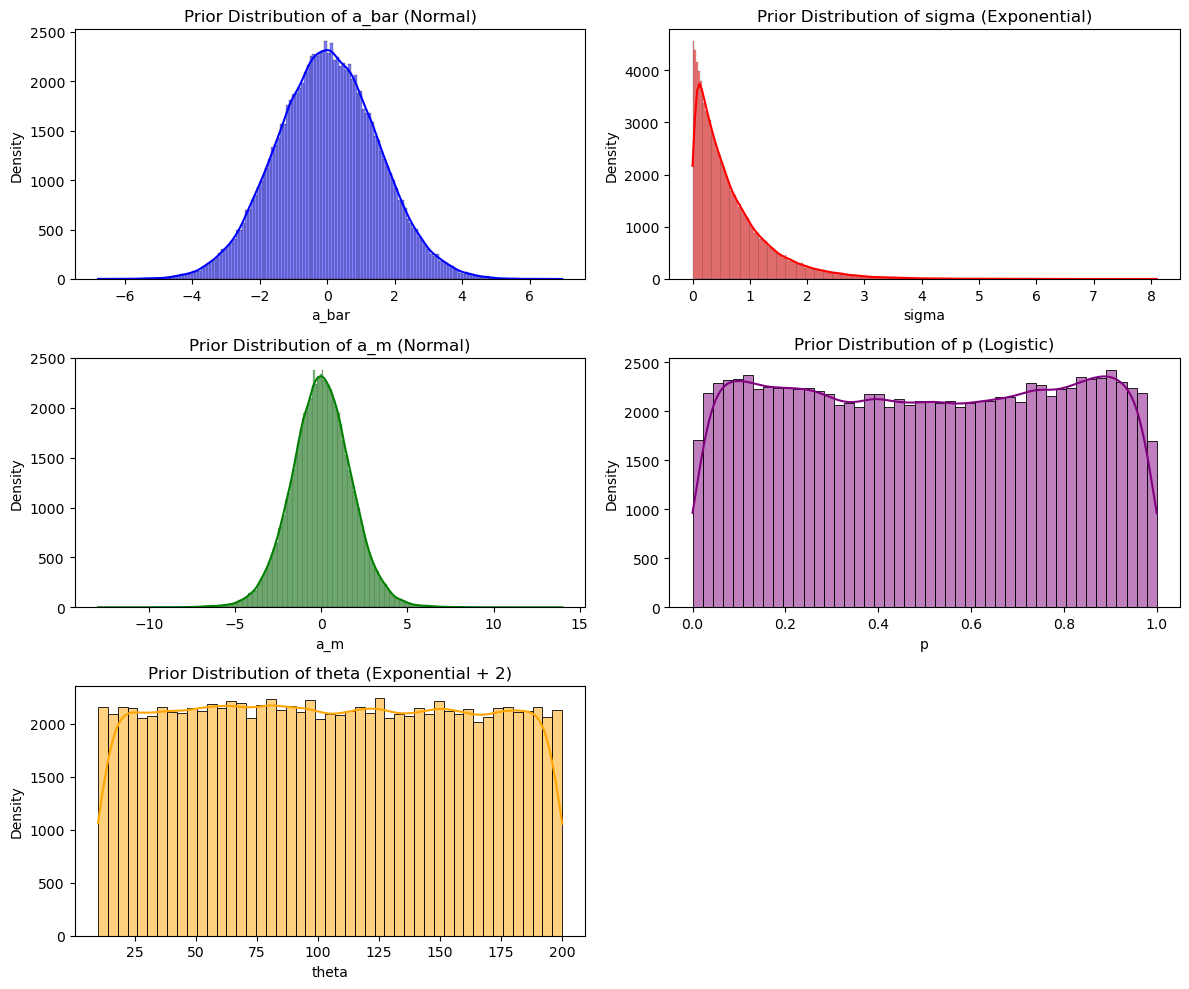

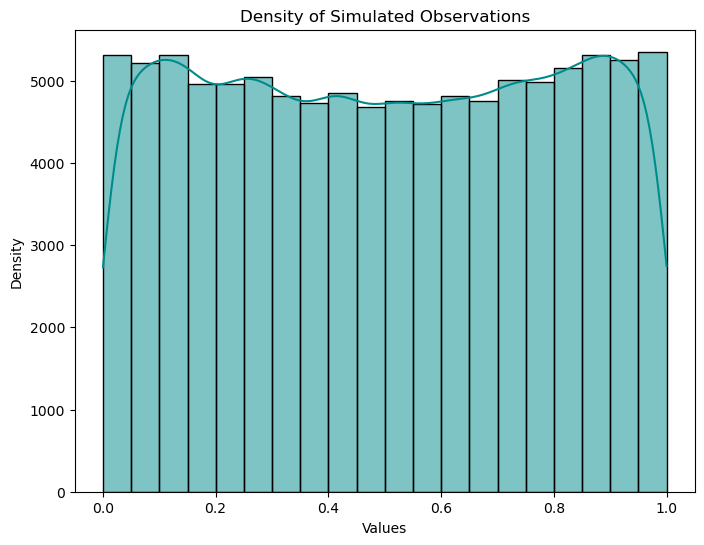

In [49]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

with pm.Model() as model:
    # Priors for the global intercept
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard deviation across groups
    sigma = pm.Exponential('sigma', 1.5)
    
    # Group-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma)
    
    # Link function - logistic
    p = pm.Deterministic('p', pm.math.invlogit(a_m))
    
    # Gamma distribution for theta - dispersion parameter
    #phi = pm.Uniform('phi', 0, 110)
    #theta = pm.Deterministic('theta', phi + 2)  # adjust alpha, beta to reflect your prior knowledge
    #theta = pm.Gamma('theta', alpha=4, beta=1)
    theta = pm.Uniform('theta', 10, 200)
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta)
    
    # Sample from the model
    #trace = pm.sample(1000, chains=4, return_inferencedata=True, progressbar=True)
    idata = pm.sample_prior_predictive(samples=100000)


prior_a_bar = idata.prior['a_bar'].values.flatten()
prior_sigma = idata.prior['sigma'].values.flatten()
prior_a_m = idata.prior['a_m'].values.flatten()
prior_p = idata.prior['p'].values.flatten()
prior_theta = idata.prior['theta'].values.flatten()



simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)


# Plotting
plt.figure(figsize=(12, 10))

plt.subplot(3, 2, 1)
sns.histplot(prior_a_bar, kde=True, color='blue')
plt.title('Prior Distribution of a_bar (Normal)')
plt.xlabel('a_bar')
plt.ylabel('Density')

plt.subplot(3, 2, 2)
sns.histplot(prior_sigma, kde=True, color='red')
plt.title('Prior Distribution of sigma (Exponential)')
plt.xlabel('sigma')
plt.ylabel('Density')

plt.subplot(3, 2, 3)
sns.histplot(prior_a_m, kde=True, color='green')
plt.title('Prior Distribution of a_m (Normal)')
plt.xlabel('a_m')
plt.ylabel('Density')

plt.subplot(3, 2, 4)
sns.histplot(prior_p, kde=True, color='purple')
plt.title('Prior Distribution of p (Logistic)')
plt.xlabel('p')
plt.ylabel('Density')

plt.subplot(3, 2, 5)
sns.histplot(prior_theta, kde=True, color='orange')
plt.title('Prior Distribution of theta (Exponential + 2)')
plt.xlabel('theta')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(simulated_observations, bins=np.arange(0, 1.05, 0.05), kde=True, color='darkcyan')
plt.title('Density of Simulated Observations')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

/tmp/ipykernel_15439/30030881.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


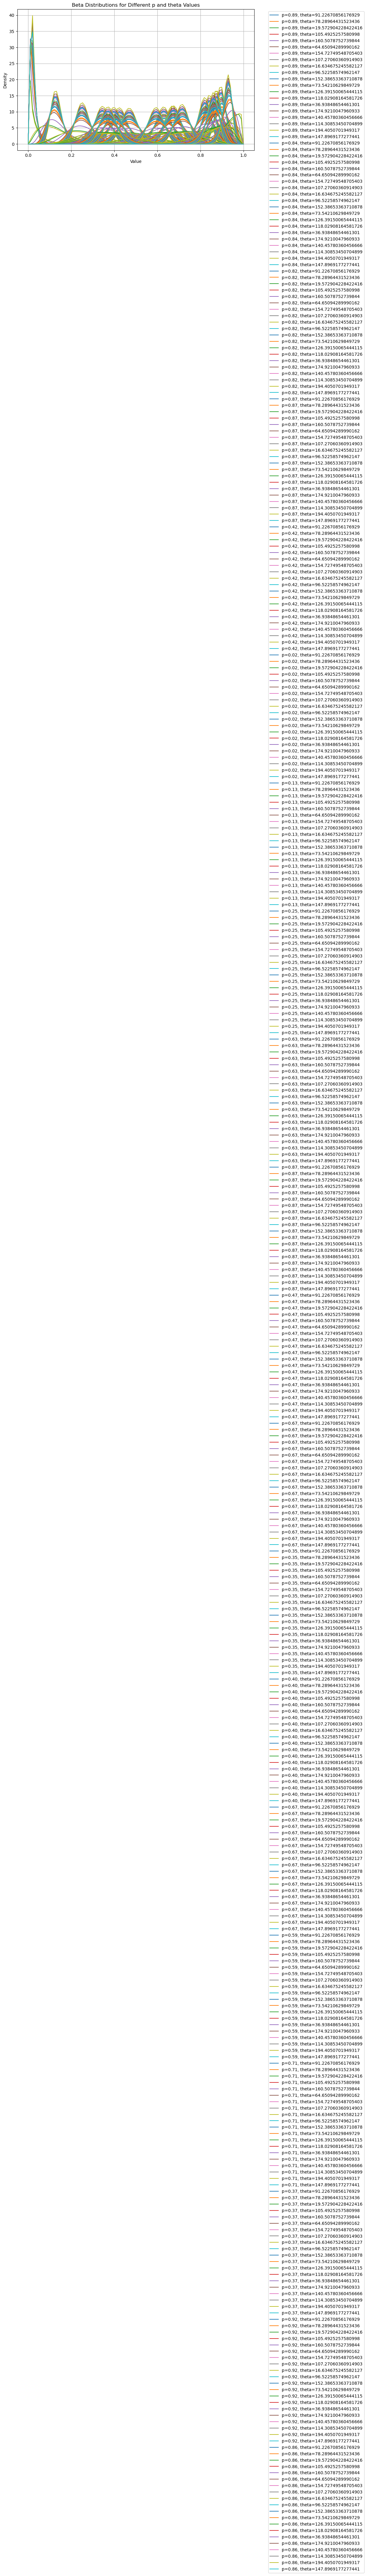

In [51]:
from scipy.stats import beta


def plot_beta_distributions(p_values, theta_values):
    """
    Plot Beta distributions for a range of p and theta values.

    Parameters:
    p_values (array-like): An array of probabilities, p.
    theta_values (array-like): An array of theta values.

    Returns:
    A matplotlib figure with the plots of Beta distributions.
    """

    x = np.linspace(0, 1, 100)  # Range of x values for the Beta distribution PDF

    plt.figure(figsize=(10, 6))
    
    for p in p_values:
        for theta in theta_values:
            # Calculate alpha and beta parameters for the Beta distribution
            a = p * theta
            b = (1 - p) * theta
            
            # Compute the probability density function for each pair of alpha (a) and beta (b)
            y = beta.pdf(x, a, b)
            
            # Plot the Beta distribution
            plt.plot(x, y, label=f'p={p:.2f}, theta={theta}')
    
    plt.title('Beta Distributions for Different p and theta Values')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()


plot_beta_distributions(prior_p[0:20], prior_theta[0:20])

In [11]:
import pymc as pm
import formulaic
import pandas as pd
import numpy as np

model_formula = 'Coverage ~ 0 + C(TargetModule) + C(TuningParameters, Treatment(reference="NONE"))'
model_spec = formulaic.model_matrix(model_formula, data=data)
model_spec.rhs.iloc[:, 24:]

C(TuningParameters, Treatment(reference='NONE'))[T.ChangeParameterProbability]  \
0                                                     0                                
1                                                     0                                
2                                                     0                                
3                                                     0                                
4                                                     0                                
...                                                 ...                                
9355                                                  0                                
9356                                                  0                                
9357                                                  0                                
9358                                                  0                                
9359                                                  0                                

      C(TuningParameters, Treatment(reference='NONE'))[T.ChromosomeLength]  \
0                                                     0                      
1                                                     0                      
2                                                     0                      
3                                                     0                      
4                                                     1                      
...                                                 ...                      
9355                                                  0                      
9356                                                  0                      
9357                                                  0                      
9358                                                  1                      
9359                                                  0                      

      C(TuningParameters, Treatment(reference='NONE'))[T.CrossoverRate]  \
0                                                     0                   
1                                                     0                   
2                                                     0                   
3                                                     0                   
4                                                     0                   
...                                                 ...                   
9355                                                  0                   
9356                                                  0                   
9357                                                  0                   
9358                                                  0                   
9359                                                  0                   

      C(TuningParameters, Treatment(reference='NONE'))[T.Elite]  \
0                                                     0           
1                                                     1           
2                                                     0           
3                                                     0           
4                                                     0           
...                                                 ...           
9355                                                  0           
9356                                                  0           
9357                                                  0           
9358                                                  0           
9359                                                  0           

      C(TuningParameters, Treatment(reference='NONE'))[T.Population]  \
0                                                     0                
1                                                     0                
2                                                     0                
3                 

In [ ]:
with pm.Model() as model:
    # Priors for the global intercept
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard deviation across groups
    sigma = pm.Exponential('sigma', 1)
    
    # Group-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma, shape=24)
    b_p = pm.Normal('b_p', mu=0, sigma = 0.5, shape= 12)
    
    # Deterministic transformations for logit(pi)
    logit_a = pm.math.dot(model_spec.rhs.iloc[:, :24], a_m)
    logit_beta = pm.math.dot(model_spec.rhs.iloc[:, 24:], b_p)
    combined = logit_a + logit_beta

    # Link function - logistic
    p = pm.Deterministic('p', pm.math.sigmoid(combined))
    
    # Gamma distribution for theta - dispersion parameter
    theta = pm.Gamma('theta', alpha=2, beta=0.5)  # adjust alpha, beta to reflect your prior knowledge
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=model_spec.lhs['Coverage'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4, return_inferencedata=True, progressbar=True)

print("Model building complete.")

In [7]:
import arviz as az

def logit_to_probability(logit_vals):
    """Apply logistic transformation to logit values."""
    return 1 / (1 + np.exp(-logit_vals))


def log_odds_to_or(log_odds):
    return np.exp(log_odds)

# Create a dictionary for the posterior
posterior_dict = {
    'a_m': trace.posterior['a_m'].values,
    
    'a_bar': trace.posterior['a_bar'].values,
    'sigma': trace.posterior['sigma'].values
    
}

for key, value in posterior_dict.items():
    posterior_dict[key] = logit_to_probability(value)


posterior_dict['theta'] = trace.posterior['theta'].values
posterior_dict['beta_p'] = trace.posterior['beta_p'].values #log_odds_to_or(trace.posterior['beta_p'].values)

# Create an InferenceData object
infdata = az.from_dict(posterior=posterior_dict)

# Generate a summary table with the mean and 89% HDI for all variables
summary = az.summary(infdata, hdi_prob=0.89)
summary
#az.summary(trace)




mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a_m[0]       0.874  0.003     0.869      0.878      0.000    0.000    1270.0   
a_m[1]       0.664  0.005     0.656      0.671      0.000    0.000     955.0   
a_m[2]       0.933  0.002     0.930      0.936      0.000    0.000    1924.0   
a_m[3]       0.052  0.002     0.049      0.055      0.000    0.000    2125.0   
a_m[4]       0.077  0.002     0.073      0.080      0.000    0.000    1978.0   
a_m[5]       0.598  0.005     0.591      0.606      0.000    0.000     824.0   
a_m[6]       0.748  0.004     0.742      0.755      0.000    0.000     966.0   
a_m[7]       0.794  0.004     0.788      0.800      0.000    0.000    1056.0   
a_m[8]       0.279  0.004     0.272      0.286      0.000    0.000     996.0   
a_m[9]       0.140  0.003     0.135      0.145      0.000    0.000    1240.0   
a_m[10]      0.227  0.004     0.221      0.233      0.000    0.000    1045.0   
a_m[11]      0.490  0.005     0.482      0.498      0.000    0.000     807.0   
a_m[12]      0.634  0.005     0.627      0.642      0.000    0.000     914.0   
a_m[13]      0.750  0.004     0.744      0.757      0.000    0.000    1058.0   
a_m[14]      0.907  0.002     0.904      0.911      0.000    0.000    1621.0   
a_m[15]      0.907  0.002     0.904      0.911      0.000    0.000    1284.0   
a_m[16]      0.324  0.005     0.317      0.331      0.000    0.000     871.0   
a_m[17]      0.471  0.005     0.463      0.479      0.000    0.000     881.0   
a_m[18]      0.229  0.004     0.223      0.235      0.000    0.000    1112.0   
a_m[19]      0.783  0.004     0.777      0.789      0.000    0.000    1053.0   
a_m[20]      0.754  0.004     0.747      0.760      0.000    0.000     931.0   
a_m[21]      0.196  0.004     0.190      0.202      0.000    0.000    1082.0   
a_m[22]      0.598  0.005     0.591      0.606      0.000    0.000     870.0   
a_m[23]      0.287  0.004     0.280      0.293      0.000    0.000     952.0   
a_bar        0.531  0.075     0.417      0.655      0.001    0.001    5137.0   
sigma        0.824  0.032     0.773      0.875      0.000    0.000    7433.0   
theta       42.273  0.629    41.229     43.251      0.007    0.005    7351.0   
beta_p[0]    0.012  0.019    -0.018      0.042      0.001    0.000     718.0   
beta_p[1]   -0.022  0.019    -0.053      0.009      0.001    0.000     749.0   
beta_p[2]   -0.005  0.019    -0.035      0.026      0.001    0.001     738.0   
beta_p[3]    0.008  0.019    -0.021      0.040      0.001    0.001     712.0   
beta_p[4]   -0.051  0.019    -0.082     -0.022      0.001    0.001     691.0   
beta_p[5]    0.008  0.019    -0.024      0.035      0.001    0.001     686.0   
beta_p[6]   -0.010  0.019    -0.041      0.020      0.001    0.000     748.0   
beta_p[7]    0.005  0.019    -0.026      0.034      0.001    0.001     686.0   
beta_p[8]   -0.022  0.019    -0.051      0.011      0.001    0.001     692.0   
beta_p[9]    0.011  0.019    -0.021      0.040      0.001    0.000     734.0   
beta_p[10]   0.028  0.019    -0.002      0.059      0.001    0.001     668.0   
beta_p[11]  -0.003  0.019    -0.035      0.025      0.001    0.001     687.0   

            ess_tail  r_hat  
a_m[0]        1745.0   1.00  
a_m[1]        1996.0   1.00  
a_m[2]        2720.0   1.00  
a_m[3]        2320.0   1.00  
a_m[4]        2079.0   1.00  
a_m[5]        1531.0   1.00  
a_m[6]        1934.0   1.00  
a_m[7]        1944.0   1.00  
a_m[8]        1807.0   1.00  
a_m[9]        2070.0   1.00  
a_m[10]       2181.0   1.00  
a_m[11]       1799.0   1.01  
a_m[12]       1968.0   1.00  
a_m[13]       1908.0   1.00  
a_m[14]       2452.0   1.00  
a_m[15]       2131.0   1.00  
a_m[16]       1788.0   1.00  
a_m[17]       1821.0   1.00  
a_m[18]       2015.0   1.00  
a_m[19]       1919.0   1.00  
a_m[20]       1741.0   1.00  
a_m[21]       1442.0   1.00  
a_m[22]       1736.0   1.00  
a_m[23]       2083.0   1.00  
a_bar         3291.0   1.00  
sigma         3137.0   1.00  
the

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'beta_p'}>,
        <Axes: title={'center': 'beta_p'}>]], dtype=object)

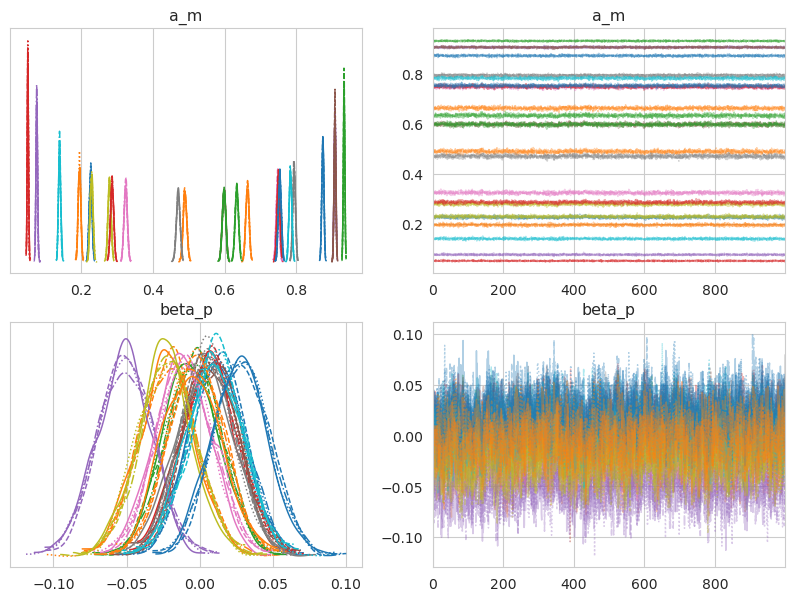

In [8]:
az.plot_trace(posterior_dict, var_names=['a_m', 'beta_p'], figsize=(10, 7))

In [22]:
az.to_netcdf(trace, "module_target_trace.nc")

'module_target_trace.nc'

In [13]:
import pymc as pm
import formulaic
import pandas as pd
import numpy as np

model_formula = 'Coverage ~ 0 + C(TargetModule) + C(TuningParameters, contr.treatment("NONE"))'
model_spec = formulaic.model_matrix(model_formula, data=data)
module_matrix = model_spec.rhs.iloc[:, :24]
parameter_matrix = model_spec.rhs.iloc[:, 24:]

model_formula = 'Coverage ~ 0 +  C(TargetModule) : C(TuningParameters)'
model_spec = formulaic.model_matrix(model_formula, data=data)

# Filter out columns that contain 'T.NONE' in their name
columns_to_drop = [col for col in model_spec.rhs.columns if 'T.NONE' in col]

# Drop the identified columns
model_spec.rhs.drop(columns=columns_to_drop, axis=1, inplace=True)
model_spec.rhs.iloc[:, 140:]

C(TargetModule)[T.sanic.helpers]:C(TuningParameters)[T.RandomPerturbation]  \
0                                                     0                            
1                                                     0                            
2                                                     0                            
3                                                     0                            
4                                                     0                            
...                                                 ...                            
9355                                                  0                            
9356                                                  0                            
9357                                                  0                            
9358                                                  0                            
9359                                                  0                            

      C(TargetModule)[T.sanic.mixins.signals]:C(TuningParameters)[T.RandomPerturbation]  \
0                                                     0                                   
1                                                     0                                   
2                                                     0                                   
3                                                     0                                   
4                                                     0                                   
...                                                 ...                                   
9355                                                  0                                   
9356                                                  0                                   
9357                                                  0                                   
9358                                                  0                                   
9359                                                  0                                   

      C(TargetModule)[T.thonny.plugins.pgzero_frontend]:C(TuningParameters)[T.RandomPerturbation]  \
0                                                     0                                             
1                                                     0                                             
2                                                     0                                             
3                                                     0                                             
4                                                     0                                             
...                                                 ...                                             
9355                                                  0                                             
9356                                                  0                                             
9357                                                  0                                             
9358                                                  0                                             
9359                                                  0                                             

      C(TargetModule)[T.typesystem.tokenize.positional_validation]:C(TuningParameters)[T.RandomPerturbation]  \
0                                                     0                                                        
1                                                     0                                                        
2                                                     0                                                        
3                                                     0                                                        
4                                                     0                                                        
...                

In [14]:
with pm.Model() as model:
    # Priors for the global intercept
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard deviation across groups
    sigma = pm.Exponential('sigma', 1)
    
    # Group-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma, shape=24)
    b_p = pm.Normal('b_p', mu=0, sigma = 0.5, shape= 12)
    g_mp = pm.Normal('g_mp', mu=0, sigma = 0.5, shape=288)
    
    # Deterministic transformations for logit(pi)
    logit_alpha = pm.math.dot(module_matrix, a_m)
    logit_beta = pm.math.dot(parameter_matrix, b_p)
    logit_gamma = pm.math.dot(model_spec.rhs, g_mp)
    combined = logit_alpha + logit_beta + logit_gamma

    # Link function - logistic
    p = pm.Deterministic('p', pm.math.sigmoid(combined))
    
    # Gamma distribution for theta - dispersion parameter
    theta = pm.Gamma('theta', alpha=2, beta=0.5)  # adjust alpha, beta to reflect your prior knowledge
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=model_spec.lhs['Coverage'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4, return_inferencedata=True, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [a_bar, sigma, a_m, b_p, g_mp, theta]


Output()

ValueError: Not enough samples to build a trace.

In [7]:
import arviz as az

def logit_to_probability(logit_vals):
    """Apply logistic transformation to logit values."""
    return 1 / (1 + np.exp(-logit_vals))


def log_odds_to_or(log_odds):
    return np.exp(log_odds)

# Create a dictionary for the posterior
posterior_dict = {
    'a_m': trace.posterior['a_m'].values,
    'a_bar': trace.posterior['a_bar'].values,
    'sigma': trace.posterior['sigma'].values
    
}

for key, value in posterior_dict.items():
    posterior_dict[key] = logit_to_probability(value)


posterior_dict['theta'] = trace.posterior['theta'].values
posterior_dict['b_p'] = trace.posterior['b_p'].values 
posterior_dict['g_mp'] = trace.posterior['g_mp'].values

# Create an InferenceData object
infdata = az.from_dict(posterior=posterior_dict)

# Generate a summary table with the mean and 89% HDI for all variables
summary = az.summary(infdata, hdi_prob=0.89)
summary

KeyError: 'sigma'

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'beta_p'}>,
        <Axes: title={'center': 'beta_p'}>],
       [<Axes: title={'center': 'gamma_mp'}>,
        <Axes: title={'center': 'gamma_mp'}>]], dtype=object)

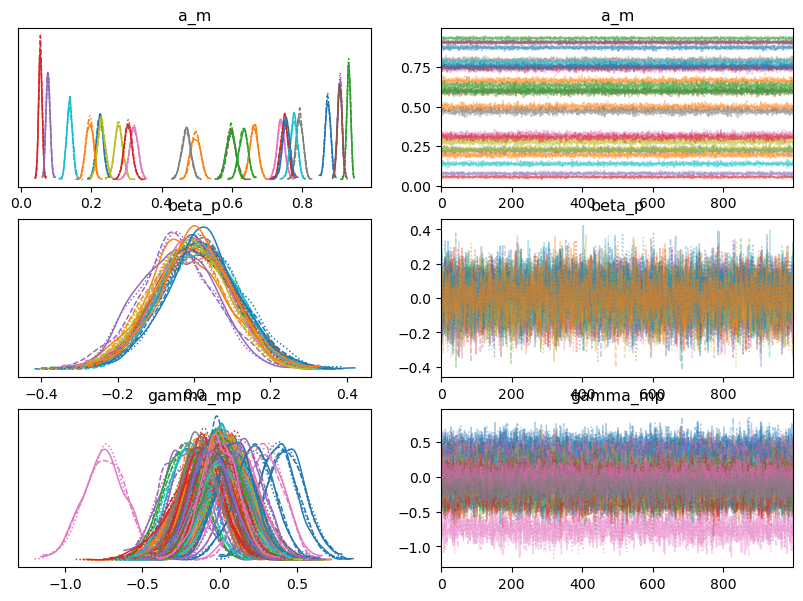

In [25]:
az.plot_trace(posterior_dict, var_names=['a_m', 'beta_p', 'gamma_mp'], figsize=(10, 7))

In [26]:
idata = az.to_netcdf(trace, 'module_parameter_iteraction.nc')

In [95]:
import pymc as pm
import formulaic
import pandas as pd
import numpy as np

data = pd.read_csv("../single_parameter/combined_data/statistics.csv")
data.head()


model_formula = 'Coverage ~ 0 + C(TargetModule) + C(TuningParameters, contr.treatment("NONE"))'
model_spec = formulaic.model_matrix(model_formula, data=data)
module_matrix = model_spec.rhs.iloc[:, :24]
parameter_matrix = model_spec.rhs.iloc[:, 24:]

model_formula = 'Coverage ~ 0 +  C(TargetModule) : C(TuningParameters)'
model_spec = formulaic.model_matrix(model_formula, data=data)

# Filter out columns that contain 'T.NONE' in their name
columns_to_drop = [col for col in model_spec.rhs.columns if 'T.NONE' in col]

# Drop the identified columns
model_spec.rhs.drop(columns=columns_to_drop, axis=1, inplace=True)
model_spec.rhs.iloc[:, 140:]


C(TargetModule)[T.sanic.helpers]:C(TuningParameters)[T.RandomPerturbation]  \
0                                                     0                            
1                                                     0                            
2                                                     0                            
3                                                     0                            
4                                                     0                            
...                                                 ...                            
9355                                                  0                            
9356                                                  0                            
9357                                                  0                            
9358                                                  0                            
9359                                                  0                            

      C(TargetModule)[T.sanic.mixins.signals]:C(TuningParameters)[T.RandomPerturbation]  \
0                                                     0                                   
1                                                     0                                   
2                                                     0                                   
3                                                     0                                   
4                                                     0                                   
...                                                 ...                                   
9355                                                  0                                   
9356                                                  0                                   
9357                                                  0                                   
9358                                                  0                                   
9359                                                  0                                   

      C(TargetModule)[T.thonny.plugins.pgzero_frontend]:C(TuningParameters)[T.RandomPerturbation]  \
0                                                     0                                             
1                                                     0                                             
2                                                     0                                             
3                                                     0                                             
4                                                     0                                             
...                                                 ...                                             
9355                                                  0                                             
9356                                                  0                                             
9357                                                  0                                             
9358                                                  0                                             
9359                                                  0                                             

      C(TargetModule)[T.typesystem.tokenize.positional_validation]:C(TuningParameters)[T.RandomPerturbation]  \
0                                                     0                                                        
1                                                     0                                                        
2                                                     0                                                        
3                                                     0                                                        
4                                                     0                                                        
...                

In [97]:
p_matrix_copy = parameter_matrix.copy()
iteraction_matrix_copy = model_spec.rhs.copy()

iteraction_to_parameter_matrix = iteraction_matrix_copy.T @ p_matrix_copy

iteraction_to_parameter_matrix = (iteraction_to_parameter_matrix > 0).astype(int)
#iteraction_to_parameter_matrix @ np.array([0.3, 0.2, 0.654, 0.553, 0.432, 0.3467,
#                                           0.1, 0.95, 0.32, 0.67, 0.43632, 0.9876])

In [98]:
with pm.Model() as model:
    # Priors for the global intercept
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    sigma_a = pm.Exponential('sigma_a', 1)
    
    g_bar = pm.Normal('g_bar', mu=0, sigma = 0.5, shape= 12)
    sigma_g = pm.Exponential('sigma_g', 1)

    # Group-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma_a, shape=24)
    g_mp = pm.Normal('g_mp', mu=pm.math.dot(iteraction_to_parameter_matrix, g_bar), sigma = sigma_g, shape=288)
                                # (288,12)->(288,1)
    # Deterministic transformations for logit(pi)
    logit_alpha = pm.math.dot(module_matrix, a_m)
    logit_gamma = pm.math.dot(model_spec.rhs, g_mp)
    combined = logit_alpha + logit_gamma

    # Link function - logistic
    p = pm.Deterministic('p', pm.math.sigmoid(combined))
    
    # Gamma distribution for theta - dispersion parameter
    theta = pm.Gamma('theta', alpha=2, beta=0.5)  # adjust alpha, beta to reflect your prior knowledge
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=model_spec.lhs['Coverage'])

    
    # Sample from the model
    trace = pm.sample(2000, chains=4, return_inferencedata=True, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma_a, g_bar, sigma_g, a_m, g_mp, theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1588 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [102]:
import arviz as az

def logit_to_probability(logit_vals):
    """Apply logistic transformation to logit values."""
    return 1 / (1 + np.exp(-logit_vals))


def log_odds_to_or(log_odds):
    return np.exp(log_odds)

# Create a dictionary for the posterior
posterior_dict = {
    'a_m': trace.posterior['a_m'].values,
    'a_bar': trace.posterior['a_bar'].values,
    'sigma': trace.posterior['sigma_a'].values
    
}

for key, value in posterior_dict.items():
    posterior_dict[key] = logit_to_probability(value)


posterior_dict['theta'] = trace.posterior['theta'].values
posterior_dict['g_mp'] = trace.posterior['g_mp'].values
posterior_dict['g_bar'] = trace.posterior['g_bar'].values
posterior_dict['sigma_g'] = trace.posterior['sigma_g'].values

# Create an InferenceData object
infdata = az.from_dict(posterior=posterior_dict)

# Generate a summary table with the mean and 89% HDI for all variables
summary = az.summary(infdata, hdi_prob=0.89)
summary.to_csv("my_data.csv")

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'g_mp'}>,
        <Axes: title={'center': 'g_mp'}>],
       [<Axes: title={'center': 'g_bar'}>,
        <Axes: title={'center': 'g_bar'}>]], dtype=object)

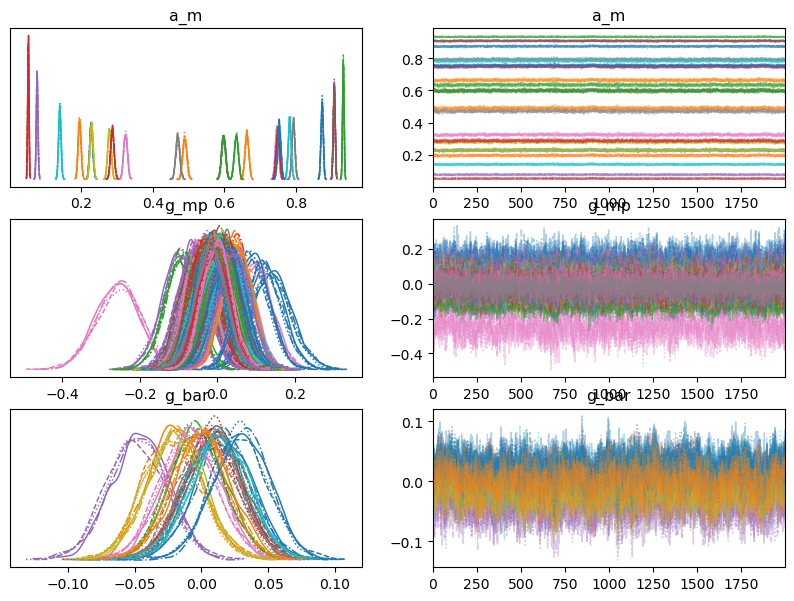

In [100]:
az.plot_trace(posterior_dict, var_names=['a_m', 'g_mp', 'g_bar'], figsize=(10, 7))

In [9]:
idata = az.to_netcdf(trace, 'module_iteraction.nc')